# Ridha: Visualization using TSNE graphs and Pydeck 

Here, I am gonna create a big data set of all the blocks' vehicle data on 10/12/2018. 

### Imports :

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import osmnx as ox
import pandas as pd
import numpy as np
from Data import Data 
import networkx as nx
from networkx import algorithms 
import math
from numpy import arctan2, sin, cos, sqrt, radians

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

In [6]:
import pydeck as pdk
import json

### Making the graph for our data:

In [135]:
graph = ox.graph_from_address('Athens, Municipality of Athens, Regional Unit of Central Athens, Attica, 10667, Greece', network_type='drive') 

### Data.py functions:

I am modifying on the data.py functions to concate the dataframes from different blocks .

In [9]:
def process_csv(name):
        "pre processing function to turn csv file into usable material for `process`"
        in_fname = name

        with open(in_fname, "r") as f:
            temp = f.readlines()
    
        rows = temp[1:]
        return rows

In [14]:
def process(row_str, H, D, col_names, idx_names):
        "Creates multi index table using 'track_id' and 'time' as the indexes. Only creates table for each index."
        parts = row_str.strip().strip(";").split(";")
        header = parts[:H]
        data = np.array(parts[H:], dtype=np.float)
        data = data.reshape(-1, D)

        # create MultiIndex from id and time
        timesteps = data[:,-1]
        id_arr = np.full(timesteps.shape, int(header[0].strip()))
        tups = list(zip(id_arr, timesteps))
        mul = pd.MultiIndex.from_tuples(tups, names=idx_names)

        data = data[:,:-1] # exclude time from data
        df = pd.DataFrame(data, columns=col_names, index=mul)
        df = df.assign(
            type=header[1].strip(),
            traveled_d=float(header[2]),
            avg_speed=float(header[3])
        )
        return df

In [25]:
def create(csv_file):
        H = 4 #header length 
        D = 6 #data length
        idx_names = ['id', 'time']
        col_names = ['lat', 'lon', 'speed', 'lon_acc', 'lat_acc']
        a = process_csv(csv_file)
        frames = [process(a[i], H, D, col_names, idx_names) for i in range(len(a))]
        df = pd.concat(frames)
        return df
    

### Feature Engineering and Aggregating functions:

I am modifying some of the feature engineering functions and creating a couple of aggregating functions. 

In [175]:
def median(df):
    medians = []
    medians.append(df.iloc[0]['type'])
    for i in ['speed', 'lon_acc', 'lat_acc', 'traveled_d', 'avg_speed', 'bearing']:
        medians.append(np.median(df[i].dropna()))
    return medians

In [134]:
def bearing(df):
    """calculates and adds bearing column to dataframe
    Example usage:
        df = csv_to_df('sample.csv')
        df = bearing(df)
    """
    df['bearing'] = \
        df.groupby('id', as_index=False, group_keys=False) \
        .apply(__calc_bearings)
    return df

In [133]:
def __bearing(c1, c2):
    """credit to https://bit.ly/3amjz0Q for bearing formula"""
    lat1,lon1 = c1
    lat2,lon2 = c2
    
    dL = lon2 - lon1
    x = cos(lon2) * sin(dL)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dL)
    return arctan2(x,y)

In [132]:
def __calc_bearings(df):
    """returns a multi-indexed dataframe of bearings at each timestep for vehicle with specified ID"""
    df1 = df
    df2 = df.shift(-1)

    c1 = (df1['lat'], df1['lon'])
    c2 = (df2['lat'], df2['lon'])
    df3 = __bearing(c1, c2)
    return df3


### Concating the dataframes and exporting the data as a csv file:

Since downloading the whole data is troublesome, I downloaded all the blocks seperately and then concated them on top of each others. I did not calculate direction or density here, because they would become categorgal variables and TSNE do not deal well with TSNE plots.

In [177]:
bl = 'Block' 
check = 0
dft = create('Block1.csv')
for i in range(1, 11):
    fil = bl+str(i)+'.csv'
    df1 = create(fil)
    df1 = bearing(df1)
    check += len(df1)
#     if i != 1: # I only ran it once for run-time cost
#         dft = pd.concat([dft, df1], axis=0)
    df2 = df1.reset_index()
    medians = []
    for i in set(df2['id']):
        medians.append(median(df2[df2['id'] ==i]))
    

In [150]:
dft.to_csv(r'./allBlocks.csv', index = False)

In [173]:
dfy = create('sample.csv')
dfy = bearing(dfy)
dfy = dfy.reset_index()

In [176]:
median(dfy[dfy['id'] ==1])

['Car', 11.6261, 0.0, 0.0, 1.81, 10.850992, -0.16900054378755736]

### Prepare the Data for the TSNE plots, also pairploting the variables 

In [178]:
dffx = pd.DataFrame(medians, columns=['type','speed', 'lon_acc', 'lat_acc', 'traveled_d', 'avg_speed', 'bearing'])
X = dffx.copy()
X=dffx.drop(['type'], axis=1)

In [185]:
pd_carsNtaxis = pd.concat([dffx[dffx['type'] == 'Car'], dffx[dffx['type'] == 'Taxi']], axis=0)
X1 = pd_carsNtaxis.copy()
X1 = pd_carsNtaxis.drop(['type'], axis=1)

#### The Whole Data Set TSNE Plot

/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.floa

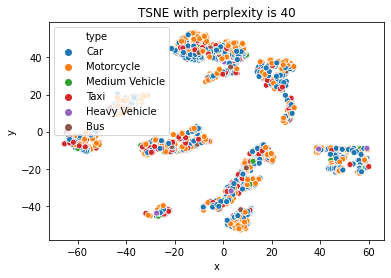

In [190]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=40, random_state=1000)
data_tsne = tsne.fit_transform(X)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=dffx.index)
dff = pd.concat([dffx, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 40")
plt.show()

#### The Car and Taxi Data Set TSNE Plot

/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Users/ridhaalkhabaz/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.floa

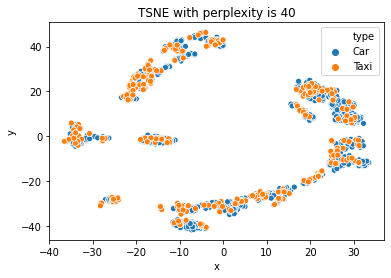

In [191]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=40, random_state=1000)
data_tsne = tsne.fit_transform(X1)


#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=pd_carsNtaxis.index)
dff = pd.concat([pd_carsNtaxis, df_tsne], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue="type", data=dff)
plt.title("TSNE with perplexity is 40")
plt.show()

#### The PairPlot figures 

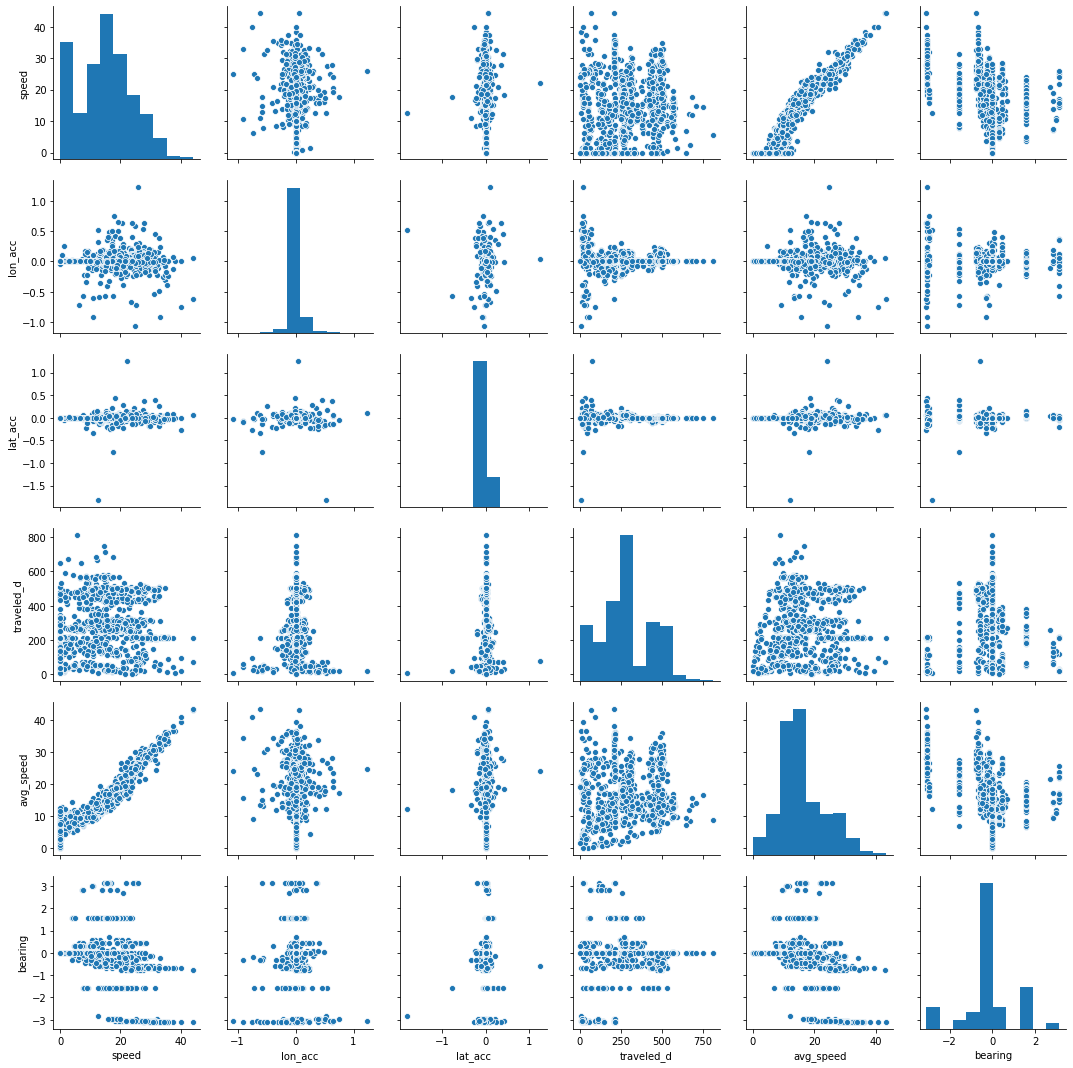

In [192]:
sns.pairplot(X1)

### The maps for the vehicles 

In [38]:
coordinates = [[i, j] for i,j in zip(df[df['type']=='Taxi']['lon'], df[df['type']=='Taxi']['lat'])]
dfx = pd.DataFrame({"coordinates": [coordinates], "timestamps" : [np.arange(0,3200,4).tolist()]})
dfx

,coordinates,timestamps
0,"[[23.735405, 37.977482], [23.735402, 37.977485...","[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, ..."


In [44]:
layer = pdk.Layer(
    "TripsLayer",
    dfx,
    get_path="coordinates",
    get_timestamps="timestamp",
    get_color=[253],
    opacity=0.8,
    width_min_pixels=5,
    rounded=True,
    trail_length=600,
    current_time=500,
)
view_state = pdk.ViewState(latitude=37.977482, longitude=23.735405, zoom=15, bearing=0, pitch=45)

In [45]:
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html("trips_layer_taxi1.html")

In [46]:
coordinates = [[i, j] for i,j in zip(df[df['type']=='Bus']['lon'], df[df['type']=='Bus']['lat'])]
dfk = pd.DataFrame({"coordinates": [coordinates], "timestamps" : [np.arange(0,3200,4).tolist()]})
dfk

,coordinates,timestamps
0,"[[23.735016, 37.978025], [23.735015, 37.978027...","[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, ..."


In [47]:
layer = pdk.Layer(
    "TripsLayer",
    dfk,
    get_path="coordinates",
    get_timestamps="timestamp",
    get_color=[253],
    opacity=0.8,
    width_min_pixels=5,
    rounded=True,
    trail_length=600,
    current_time=500,
)
view_state = pdk.ViewState(latitude=37.977482, longitude=23.735405, zoom=15, bearing=0, pitch=45)

In [49]:
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html("trips_layer_Bus2.html")